In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from mpl_toolkits.basemap import Basemap
import seawater as sw
import datetime
%matplotlib inline

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
ps = xr.open_dataset('/home/soontiensn/data/gpsc-work2/OPP/opendrift_test/C-A-C/DriftMap/riops-ps/output/riopsps_od_2019101300_P6DT23H.nc')
latlon = xr.open_dataset('/home/soontiensn/data/gpsc-work2/OPP/opendrift_test/C-A-C/DriftMap/riops-latlon/output/riopslatlon_od_2019101300_P6DT23H.nc')


In [3]:
ps

<xarray.Dataset>
Dimensions:     (model_run: 625, time: 168)
Coordinates:
  * time        (time) datetime64[ns] 2019-10-13 ... 2019-10-19T23:00:00
Dimensions without coordinates: model_run
Data variables:
    mod_lat     (model_run, time) float32 ...
    mod_lon     (model_run, time) float32 ...
    mod_dist    (model_run, time) float64 ...
    mod_disp    (model_run, time) float64 ...
    track_dist  (model_run, time) float64 ...
    ratio       (model_run, time) float64 ...
Attributes:
    mod_atmos_model:                                  None
    mod_drifter_depth:                                0c
    mod_alpha_wind:                                   0.0
    mod_nb_output:                                    167
    mod_run_name:                                     riopsps_od_2019101300_P...
    mod_ocean_model:                                  riopsPS
    mod_Conventions:                                  CF-1.6
    mod_standard_name_vocabulary:                     CF-1.6
    mod_fe

In [4]:
start = datetime.datetime(2019,10,13)
dates = [start + datetime.timedelta(days=n) for n in range(7)]
dates.append(ps.time.values[-1])
dist = np.zeros((latlon.mod_lon.shape[0],len(dates)))
for n, d in enumerate(dates):
    ps_sel = ps.sel(time=d)
    latlon_sel = latlon.sel(time=d)
    for p in range(dist.shape[0]):
        lat = np.array([latlon_sel.mod_lat.values[p], ps_sel.mod_lat.values[p]])
        lon = np.array([latlon_sel.mod_lon.values[p], ps_sel.mod_lon.values[p]])
        dist[p, n] = sw.dist(lat,lon)[0] # distance defualts in km

In [5]:
def plot_Scatter(bmap, dist, lat_orig, lon_orig):
    x, y = bmap(lon_orig, lat_orig)
    mesh = bmap.scatter(x,y,c=dist)
    cbar=plt.colorbar(mesh,ax=ax)
    cbar.set_label('separation [km]',fontsize=16)
    cbar.ax.tick_params(labelsize=16)
    bmap.drawcoastlines()

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """


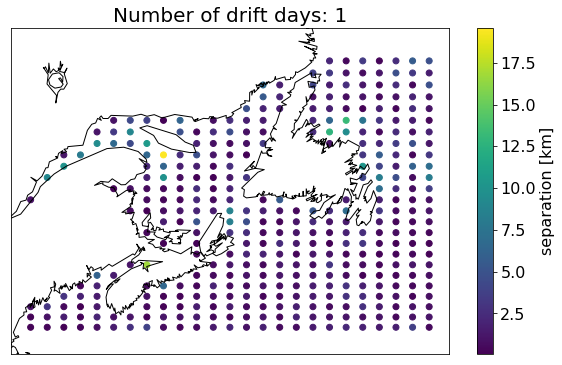

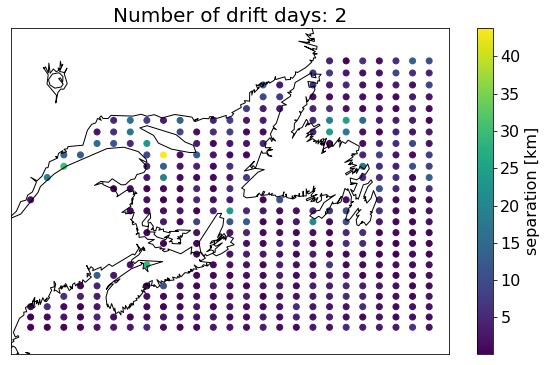

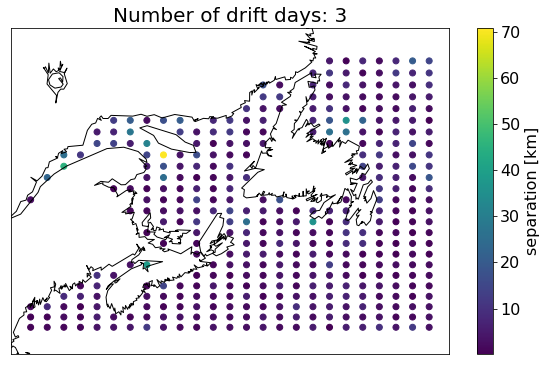

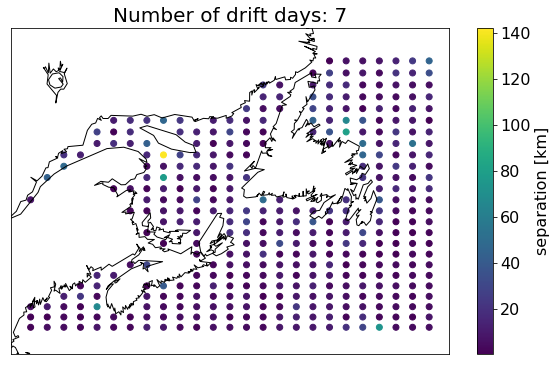

In [6]:
init_lon=latlon.mod_lon.values[:,0]
init_lat=latlon.mod_lat.values[:,0]
for n, date in enumerate(dates):
    fig,ax = plt.subplots(1,1, figsize=(10,6))
    m = Basemap(projection='merc',llcrnrlat=42,urcrnrlat=53,llcrnrlon=-71,urcrnrlon=-49,resolution='l')
    plot_Scatter(m, dist[:,n],init_lat,init_lon)
    ax.set_title('Number of drift days: {}'.format(n),fontsize=20)
fig.savefig('figures/riops_latlonVSps_{}days_grid.png'.format(n), bbox_inches='tight')

In [7]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(dates,np.nanmax(dist, axis=0))
ax.set_ylabel('Maximum separation [km]')
ax.grid()

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


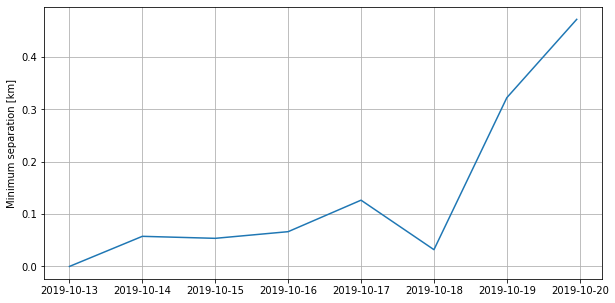

In [8]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(dates,np.nanmin(dist, axis=0))
ax.set_ylabel('Minimum separation [km]')
ax.grid()

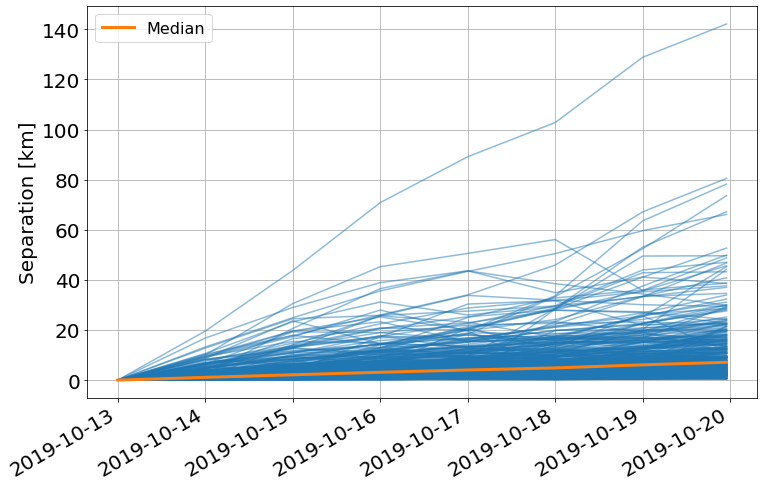

In [9]:
fig,ax=plt.subplots(1,1,figsize=(12,8))

ax.set_ylabel('Separation [km]', fontsize=20)
for i in range(dist.shape[0]):
    ax.plot(dates,dist[i], c='C0',alpha=0.5)
ax.plot(dates,np.nanmedian(dist, axis=0),c='C1',lw=3)
ax.grid()
#fake legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='C1', lw=3)]
ax.legend(custom_lines, ['Median'],fontsize=16)
ax.tick_params(axis='both', labelsize=20)
fig.autofmt_xdate()
fig.savefig('figures/riops_latlonVSps_median_sep.png', bbox_inches='tight')

In [10]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(dates,np.count_nonzero(np.isnan(dist), axis=0))
ax.set_ylabel('Number of ejected particles')
ax.grid()

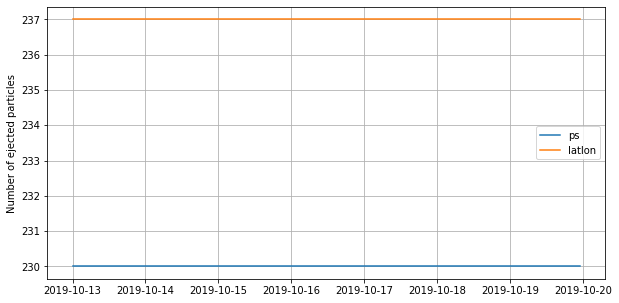

In [11]:
dummy_ps = np.zeros((ps.mod_lon.shape[0],len(dates)))
dummy_latlon = np.zeros((latlon.mod_lon.shape[0],len(dates)))
for n, d in enumerate(dates):
    ps_sel = ps.sel(time=d)
    latlon_sel = latlon.sel(time=d)
    dummy_ps[:, n] = ps_sel.mod_lon.values
    dummy_latlon[:, n] = latlon_sel.mod_lon.values
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(dates,np.count_nonzero(np.isnan(dummy_ps), axis=0),label='ps')
ax.plot(dates,np.count_nonzero(np.isnan(dummy_latlon), axis=0),label='latlon')
ax.set_ylabel('Number of ejected particles')
ax.legend()
ax.grid()

How do I isolate which of these particles are on land?

In [12]:
def plot_Scatter(bmap, lat1,lon1, lat2, lon2):
    x1, y1 = bmap(lon1, lat1)
    x2, y2 = bmap(lon2, lat2)
    bmap.plot(x1,y1,'.C0',ms=1)
    bmap.plot(x2,y2,'.C1',ms=1)
    bmap.drawcoastlines()

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


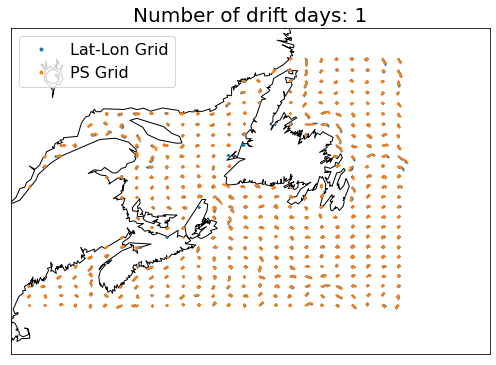

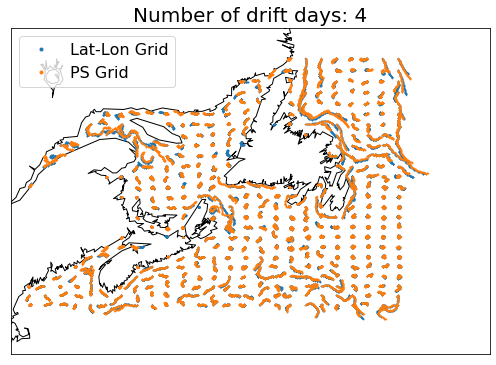

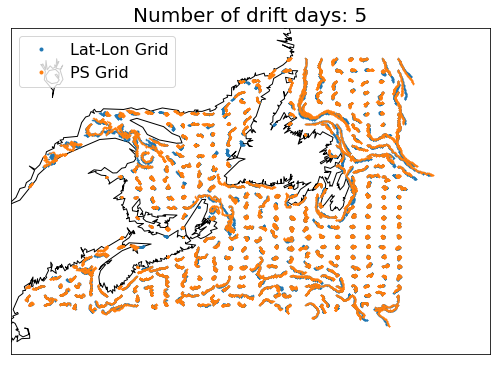

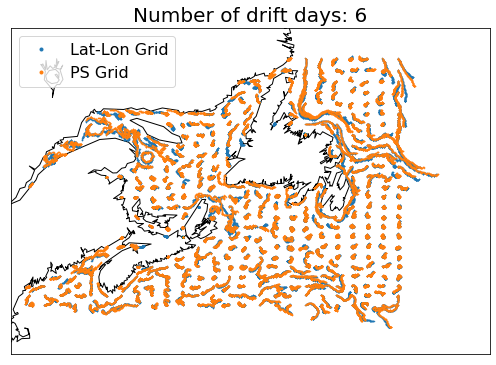

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


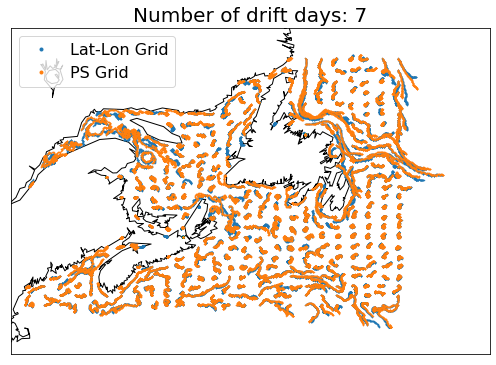

In [13]:
start=dates[0]
for n, date in enumerate(dates):
    fig,ax = plt.subplots(1,1, figsize=(10,6))
    m = Basemap(projection='merc',llcrnrlat=41,urcrnrlat=53,llcrnrlon=-71,urcrnrlon=-45,resolution='l',ax=ax)
    lat_latlon = latlon.sel(time=slice(start,date)).mod_lat.values
    lon_latlon = latlon.sel(time=slice(start,date)).mod_lon.values
    lat_ps = ps.sel(time=slice(start,date)).mod_lat.values
    lon_ps = ps.sel(time=slice(start,date)).mod_lon.values
    plot_Scatter(m, lat_latlon,lon_latlon, lat_ps,lon_ps)
    ax.set_title('Number of drift days: {}'.format(n), fontsize=20)
        # fake legend
    custom_lines = [Line2D([0], [0], marker='.', color='C0', lw=0),
                Line2D([0], [0], marker='.', color='C1', lw=0)]
    ax.legend(custom_lines, ['Lat-Lon Grid', 'PS Grid'],fontsize=16)
fig.savefig('figures/riops_latlonVSps_{}days.png'.format(n), bbox_inches='tight')